# **Data Preparation**

In [ ]:
import os
import re
import string
import json

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df_yelp_business = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_business.json', lines=True)
df_yelp_business.fillna('NA', inplace=True)
# we want to make sure we only work with restaurants -- nothing else
df_yelp_business = df_yelp_business[df_yelp_business['categories'].str.contains('Restaurants')]
print('Final Shape: ',df_yelp_business.shape)

Final Shape:  (50763, 14)


In [ ]:
df_yelp_review_iter = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_review.json', chunksize=100000, lines=True)

In [ ]:
df_yelp_review = pd.DataFrame()
i=0
for df in df_yelp_review_iter:
    df = df[df['business_id'].isin(df_yelp_business['business_id'])]
    df_yelp_review = pd.concat([df_yelp_review, df])
    i=i+1
    print(i)
    if i==4: break

1
2
3
4


In [ ]:
df_yelp_business = df_yelp_business[df_yelp_business['business_id'].isin(df_yelp_review['business_id'])]

In [ ]:
print('Final businesses shape: ', df_yelp_business.shape)
print('Final review shape: ', df_yelp_review.shape)

Final businesses shape:  (4623, 14)
Final review shape:  (277523, 9)


In [ ]:
def clean_text(text):
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)    
    return text

In [ ]:
%%time
df_yelp_review['text'] = df_yelp_review['text'].apply(clean_text)

CPU times: user 1min 26s, sys: 4.55 s, total: 1min 30s
Wall time: 1min 30s


In [ ]:
vectorizer_reviews = CountVectorizer(min_df = .01,max_df = .99, tokenizer = WordPunctTokenizer().tokenize)
vectorized_reviews = vectorizer_reviews.fit_transform(df_yelp_review['text'])

In [ ]:
print(vectorized_reviews.shape)

(277523, 926)


In [ ]:
' | '.join(vectorizer_reviews.get_feature_names()[:100]) # only the first 100

'! | + | - | 00 | 1 | 10 | 12 | 15 | 2 | 20 | 3 | 30 | 4 | 5 | 50 | 6 | 7 | 8 | : | ; | a | able | about | absolutely | across | actually | add | added | addition | after | afternoon | again | ago | all | almost | along | already | also | although | always | am | amazing | ambiance | ambience | american | amount | and | another | anyone | anything | anyway | anywhere | appetizer | appetizers | are | area | around | arrived | as | asian | ask | asked | at | ate | atlanta | atmosphere | attention | attentive | austin | authentic | available | average | avocado | away | awesome | awful | back | bacon | bad | baked | bar | barely | bartender | based | basically | bbq | be | beans | beautiful | beef | beer | beers | before | behind | believe | belly | best | better | big | bill'

In [ ]:
vectorizer_categories = CountVectorizer(min_df = 1, max_df = 1., tokenizer = lambda x: x.split(', '))
vectorized_categories = vectorizer_categories.fit_transform(df_yelp_business['categories'])

In [ ]:
print(vectorized_categories.shape)

(4623, 356)


In [ ]:
' | '.join(vectorizer_categories.get_feature_names()[:100]) # only the first 100

'acai bowls | accessories | active life | adult education | adult entertainment | afghan | african | amateur sports teams | american (new) | american (traditional) | amusement parks | animal shelters | apartments | aquariums | arabian | arcades | argentine | art classes | art galleries | arts & crafts | arts & entertainment | asian fusion | austrian | automotive | bagels | bakeries | barbeque | barbers | bars | basque | beauty & spas | bed & breakfast | beer | beer bar | beer gardens | belgian | beverage store | bistros | boat charters | boat tours | boating | books | bowling | brasseries | brazilian | breakfast & brunch | breweries | brewpubs | british | bubble tea | buffets | burgers | burmese | butcher | cabaret | cafes | cafeteria | cajun/creole | cambodian | campgrounds | canadian (new) | candy stores | cantonese | car dealers | caribbean | carpet cleaning | caterers | champagne bars | cheese shops | cheesesteaks | chicken shop | chicken wings | child care & day care | chinese | c

In [ ]:
%%time
from scipy import sparse
businessxreview = sparse.csr_matrix(pd.get_dummies(df_yelp_review['business_id']).values)

CPU times: user 8.14 s, sys: 358 ms, total: 8.5 s
Wall time: 8.5 s


In [ ]:
%%time
from scipy import sparse
businessxreview = sparse.csr_matrix(pd.get_dummies(df_yelp_review['business_id']).values)

CPU times: user 8.12 s, sys: 240 ms, total: 8.36 s
Wall time: 8.36 s


In [ ]:
print('restuarants x categories: \t', vectorized_categories.shape) 
print('restuarants x reviews: \t\t' , businessxreview.shape) 
print('reviews x words: \t\t', vectorized_reviews.shape)

restuarants x categories: 	 (4623, 356)
restuarants x reviews: 		 (277523, 4623)
reviews x words: 		 (277523, 926)


In [ ]:
df_yelp_tips = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_tip.json', lines=True)
df_yelp_tips.head()

,user_id,business_id,text,date,compliment_count
0,WCjg0jdHXMlwbqS9tZUx8Q,ENwBByjpoa5Gg7tKgxqwLg,Carne asada chips...,2011-07-22 19:07:35,0
1,42-Z02y9bABShAGZhuSzrQ,jKO4Og6ucdX2-YCTKQVYjg,Best happy hour from 3pm to 6pm! $1 off martin...,2014-09-10 07:33:29,0
2,5u7E3LYp_3eB8dLuUBazXQ,9Bto7mky640ocgezVKSfVg,"Nice people, skilled staff, clean location - b...",2013-12-13 23:23:41,0
3,wDWoMG5N9oI4DJ-p7z8EBg,XWFjKtRGZ9khRGtGg2ZvaA,"1/2-price bowling & the ""Very"" Old Fashion are...",2017-07-11 23:07:16,0
4,JmuFlorjjRshHTKzTwNtgg,mkrx0VhSMU3p3uhyJGCoWA,"Solid gold's. Great sauna. Great staff, too. E...",2016-11-30 08:46:36,0


## **Handle Missing Data**

In [ ]:
# simple data checking - get row and column of dataframe
print('simple data checking of yelp_business: ',df_yelp_business.shape, df_yelp_business.columns)
print('simple data checking of yelp_review: ',df_yelp_review.shape, df_yelp_review.columns)

simple data checking of yelp_business:  (4623, 14) Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
simple data checking of yelp_review:  (277523, 9) Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


In [ ]:
# check standard missing value - multiple column
missing_data = df_yelp_business.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

business_id
False    4623
Name: business_id, dtype: int64

name
False    4623
Name: name, dtype: int64

address
False    4623
Name: address, dtype: int64

city
False    4623
Name: city, dtype: int64

state
False    4623
Name: state, dtype: int64

postal_code
False    4623
Name: postal_code, dtype: int64

latitude
False    4623
Name: latitude, dtype: int64

longitude
False    4623
Name: longitude, dtype: int64

stars
False    4623
Name: stars, dtype: int64

review_count
False    4623
Name: review_count, dtype: int64

is_open
False    4623
Name: is_open, dtype: int64

attributes
False    4623
Name: attributes, dtype: int64

categories
False    4623
Name: categories, dtype: int64

hours
False    4623
Name: hours, dtype: int64



In [ ]:
# check standard missing value - multiple column
missing_data = df_yelp_review.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

review_id
False    277523
Name: review_id, dtype: int64

user_id
False    277523
Name: user_id, dtype: int64

business_id
False    277523
Name: business_id, dtype: int64

stars
False    277523
Name: stars, dtype: int64

useful
False    277523
Name: useful, dtype: int64

funny
False    277523
Name: funny, dtype: int64

cool
False    277523
Name: cool, dtype: int64

text
False    277523
Name: text, dtype: int64

date
False    277523
Name: date, dtype: int64



## **Handle Date Column**

In [ ]:
# simple data checking - check 1 of the date column
df_yelp_review['date'].head(15)

0    2014-10-11 03:34:02
3    2010-01-08 02:29:15
4    2011-07-28 18:05:01
5    2018-01-21 04:41:03
6    2006-04-16 02:58:44
7    2017-12-02 18:16:13
9    2014-05-07 18:10:21
10   2017-09-08 23:26:10
12   2011-10-27 14:32:57
14   2016-08-12 21:59:03
15   2015-10-04 05:37:01
16   2014-02-05 21:09:05
17   2018-03-03 23:45:25
18   2012-12-04 04:29:47
19   2013-08-15 14:47:40
Name: date, dtype: datetime64[ns]

In [ ]:
df_yelp_review["date"].value_counts()

2013-06-04 16:22:45    2
2015-11-01 23:35:41    2
2017-03-06 05:53:18    2
2018-03-06 00:44:05    2
2015-12-25 23:01:26    2
                      ..
2017-03-22 14:48:50    1
2013-11-27 07:43:50    1
2016-08-07 06:48:08    1
2015-05-13 11:11:16    1
2013-09-15 18:55:58    1
Name: date, Length: 277262, dtype: int64

In [ ]:
# change to date type & change date format
series_date_in_date = pd.to_datetime(df_yelp_review["date"],errors='raise',dayfirst=False,yearfirst=True,utc=True)
series_date_in_date

0        2014-10-11 03:34:02+00:00
3        2010-01-08 02:29:15+00:00
4        2011-07-28 18:05:01+00:00
5        2018-01-21 04:41:03+00:00
6        2006-04-16 02:58:44+00:00
                    ...           
399993   2009-07-15 22:54:18+00:00
399994   2017-07-06 03:56:36+00:00
399996   2011-03-05 06:28:11+00:00
399997   2011-06-18 20:33:27+00:00
399999   2018-02-18 03:47:39+00:00
Name: date, Length: 277523, dtype: datetime64[ns, UTC]

In [ ]:
# parsing date column
series_date_in_date = pd.to_datetime(df_yelp_review["date"],errors='raise',dayfirst=False,yearfirst=True,utc=True)

In [ ]:
series_date_in_date.dt.day

0         11
3          8
4         28
5         21
6         16
          ..
399993    15
399994     6
399996     5
399997    18
399999    18
Name: date, Length: 277523, dtype: int64

In [ ]:
series_date_in_date.dt.month

0         10
3          1
4          7
5          1
6          4
          ..
399993     7
399994     7
399996     3
399997     6
399999     2
Name: date, Length: 277523, dtype: int64

In [ ]:
df_yelp_review["year"] = series_date_in_date.dt.year

# **Exploratory Data Analysis (EDA)**

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

## **Overview of reviews**

In [ ]:
useful_reviews = len(df_yelp_review[df_yelp_review["useful"]>0])
cool_reviews = len(df_yelp_review[df_yelp_review["cool"]>0])
funny_reviews = len(df_yelp_review[df_yelp_review["funny"]>0])
negative_reviws = len(df_yelp_review[df_yelp_review["stars"]<2])
positive_reviews =len(df_yelp_review[df_yelp_review["stars"]>3])
total_reviews = len(df_yelp_review)

print("Total reviews: {}".format(total_reviews))
print("Useful reviews: {}".format(useful_reviews))
print("Funny reviews: {}".format(funny_reviews))
print("Cool reviews: {}".format(cool_reviews))
print("Total negative reviews: {}".format(negative_reviws))
print("Total positive reviews: {}".format(positive_reviews))

Total reviews: 277523
Useful reviews: 105752
Funny reviews: 45337
Cool reviews: 54348
Total negative reviews: 27823
Total positive reviews: 185112


## **Top reviewed business**

In [ ]:
top_reviewed = df_yelp_review[df_yelp_review["stars"]>3]
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)

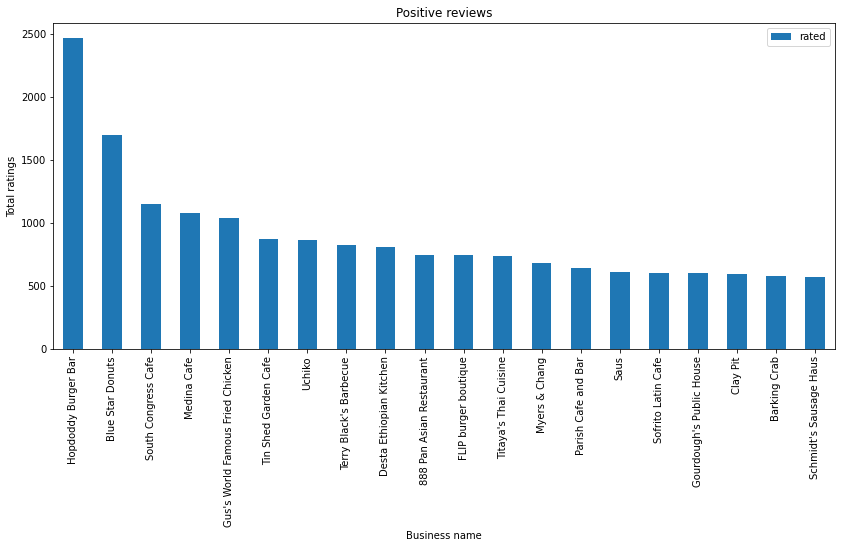

In [ ]:
top_count= 20
right=pd.DataFrame(df_yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)

## **What are the locations of top reviewed businesses**
Generally customers are eager to know what are the locations of best business outlets etc. In this section we will find locations of top best reviwed business locations and show in map.

In [ ]:
num_business = 300
business_ids = top_business_data.sort_values("rated")[::-1][:num_business].business_id.values
#len(business_ids)
useful_b = df_yelp_business.loc[df_yelp_business['business_id'].isin(business_ids)]

#len(useful_b)

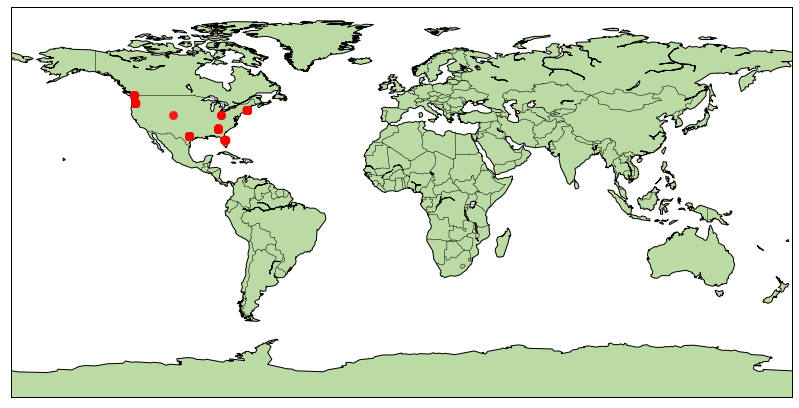

In [ ]:
fig = plt.figure(figsize=(14, 8), edgecolor='w')

m = Basemap(projection='cyl',llcrnrlon= -180, urcrnrlon = 180,
            llcrnrlat = -90, urcrnrlat= 90,resolution='c',
           lat_ts = True)
m.drawcoastlines()
m.fillcontinents(color='#bbdaa4',lake_color='#FFFFFF')
m.drawcountries()
m.drawmapboundary(fill_color='#FFFFFF')

mloc = m(useful_b['latitude'].tolist(),useful_b['longitude'].tolist())
m.scatter(mloc[1],mloc[0],color ='red',lw=3,alpha=0.3,zorder=5)

## **How businesses are getting reviewed over time**
Some businesses try to maintain their overall quality standards and make their customers happy. Lets see which businesses are maintaining their quality standards based on positive reviews.

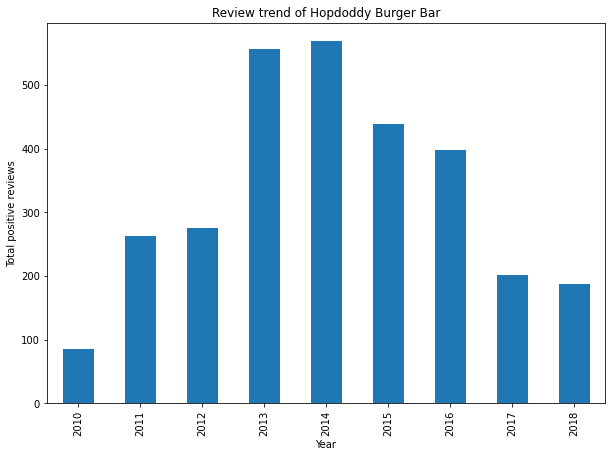

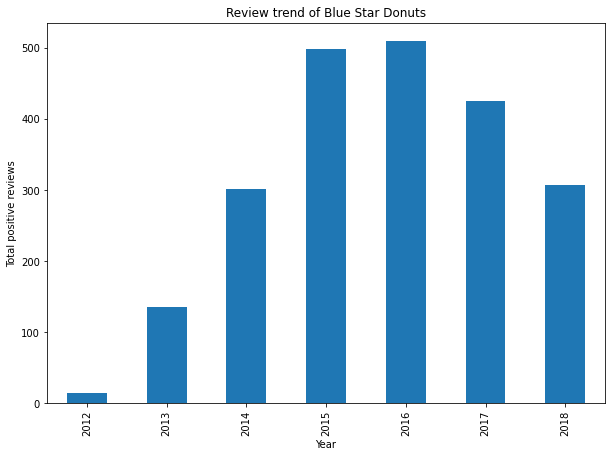

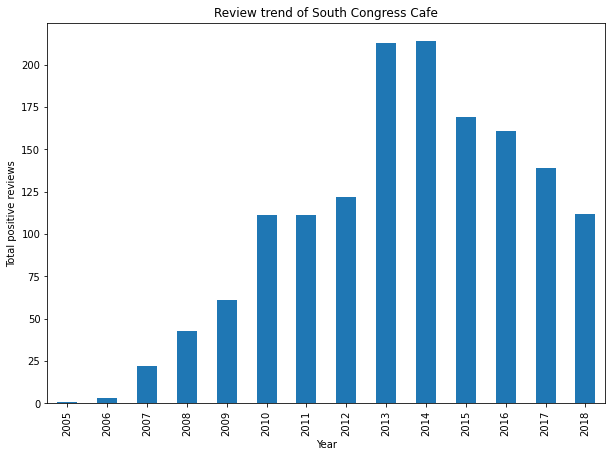

In [ ]:
num_business = 3
business_ids = top_business_data.sort_values("rated")[::-1][:num_business].business_id.values
business_names = top_business_data.sort_values("rated")[::-1][:num_business]["Business name"].values
for i, business_id in enumerate(business_ids):
    useful_b = df_yelp_review.loc[df_yelp_review['business_id'] == business_id]
    useful_b = useful_b.groupby(['year']).size().reset_index(name='counts')
    #print(useful_b.head())
    series = pd.Series(useful_b["counts"].values, index=useful_b["year"].values, name='Review trend')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total positive reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_names[i]), axes=axes)
    plt.show()

## **Most recent Trending businesses**

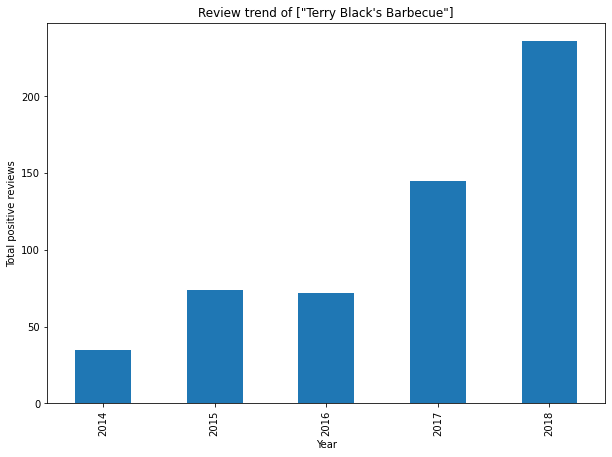

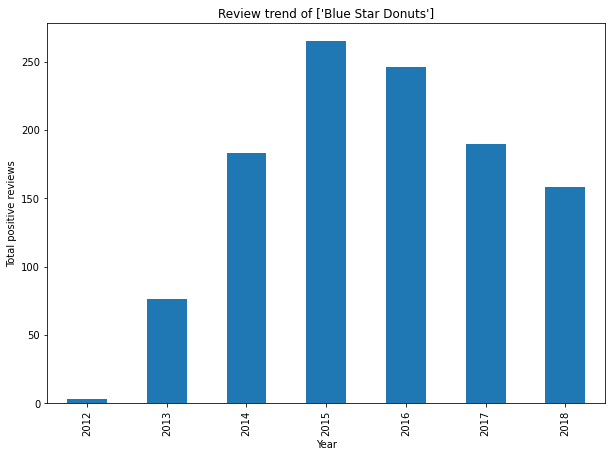

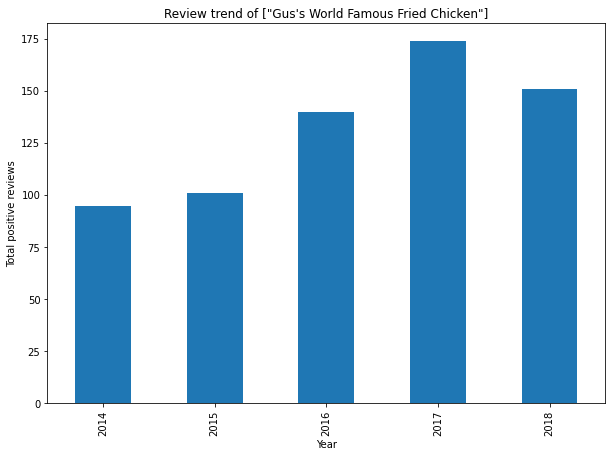

In [ ]:
top_business = 3
temp = df_yelp_review[["business_id",'year',"stars"]]
five_star_reviews = temp[temp["stars"]>4]
trending_business_reviews = five_star_reviews.groupby(["business_id",'year']).size().reset_index(name='counts')

trending = trending_business_reviews.sort_values(['year','counts'])[::-1][:top_business].business_id.values
for  business_id in trending:
    record = trending_business_reviews.loc[trending_business_reviews['business_id'] == business_id]
    business_name = df_yelp_business.loc[df_yelp_business['business_id'] == business_id].name.values
    series = pd.Series(record["counts"].values, index=record.year.values, name='Trending business')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total positive reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_name), axes=axes)
    plt.show()
    #len(trending_business_reviews)

## **Categories of top reviewed businesses**

<AxesSubplot:ylabel='Top business types'>

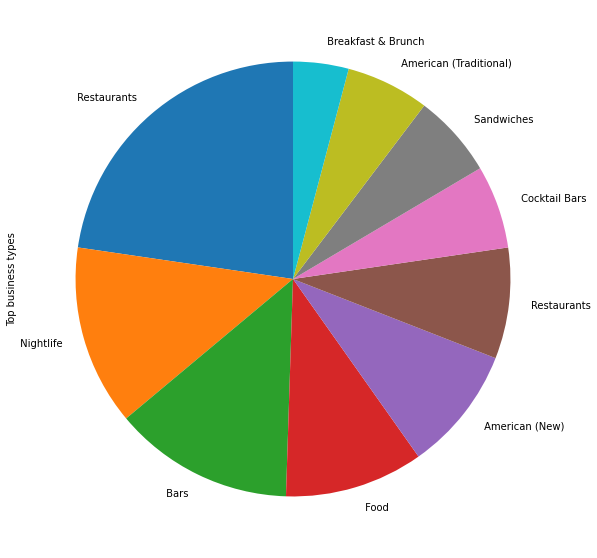

In [ ]:
num_cat =10 # to show top 10 catrgories
top_business = 30 # choose categories of top 30 businesses
cat_data = top_business_data.sort_values("rated")[::-1][:top_business]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(",")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)

## **Categories of trending businesses**

<AxesSubplot:ylabel='Top business types'>

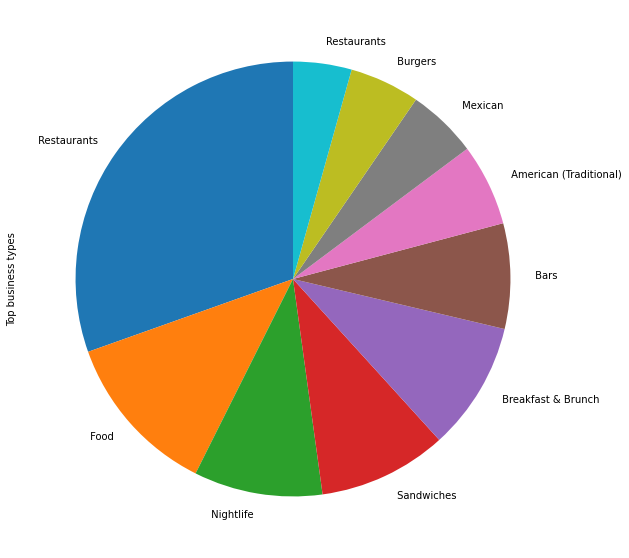

In [ ]:
num_cat =10 # to show top 10 catrgories
top_business = 40 # choose categories of top 30 businesses
business_ids = trending_business_reviews.sort_values(['year','counts'])[::-1][:top_business].business_id.values
cat_data = top_business_data.loc[top_business_data['business_id'].isin(business_ids)]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(",")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)

## **Negatively reviewed businesses**

In [ ]:
bottom_reviewed = df_yelp_review[df_yelp_review["stars"]<2]
bottom_reviews_dict ={} 

for business_id in bottom_reviewed["business_id"].values:
    try :
        bottom_reviews_dict[business_id] =bottom_reviews_dict[business_id]+1
    except:
        bottom_reviews_dict[business_id]=1
        
bottombusiness = pd.DataFrame.from_dict(data= bottom_reviews_dict,orient="index")

bottombusiness.reset_index(inplace=True)
#bottombusiness.head()
bottombusiness.columns = ['business_id', 'rated']

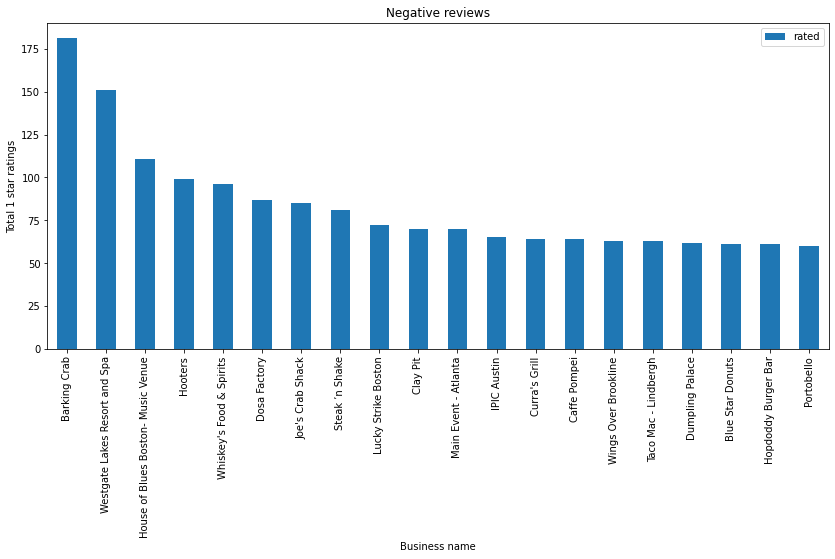

In [ ]:
top_count= 20
right=pd.DataFrame(df_yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

bottom_business_data = pd.merge(bottombusiness,right=right, how="inner",on='business_id')
bottom_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews').set_ylabel("Total 1 star ratings")

del(bottom_reviewed)
del(bottom_reviews_dict)
del(bottombusiness)
del(right)

## **Business categories which needs improvement**

<AxesSubplot:ylabel='Categories'>

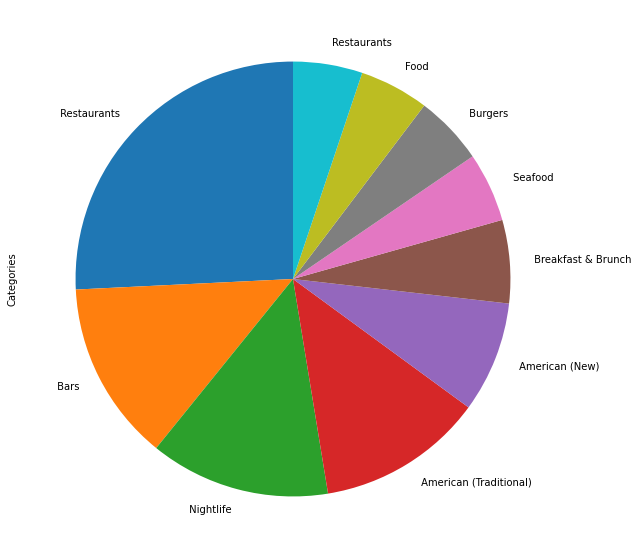

In [ ]:
num_cat =10 # to show top 10 catrgories
bottom_business = 30 # choose categories of top 30 businesses
cat_data = bottom_business_data.sort_values("rated")[::-1][:bottom_business]

Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(",")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
bottom_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
bottom_categories.reset_index(inplace=True)
bottom_categories.columns = ['category', 'occurance']

x_val=bottom_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=bottom_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Categories')
series.plot.pie(figsize=(10, 10),startangle=90)

## **Most frequent words in Positive and Negative reviews**

In [ ]:
import collections
from wordcloud import WordCloud

In [ ]:
# these are helper functions 
# directly copied from https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52

def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words


def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

Analysing business:  Hopdoddy Burger Bar
----- 10 most common 2-word phrase -----
truffle fries: 474
wait line: 271
best burger: 243
worth wait: 238
magic shroom: 188
tuna burger: 176
long line: 173
best burgers: 173
ahi tuna: 173
waiting line: 164

----- 10 most common 3-word phrase -----
ahi tuna burger: 129
best burger ever: 88
parmesan truffle fries: 78
magic shroom burger: 71
one best burgers: 61
best burgers ever: 59
chili cheese fries: 47
burger truffle fries: 37
gluten free bun: 32
nutella chocolate pretzel: 31



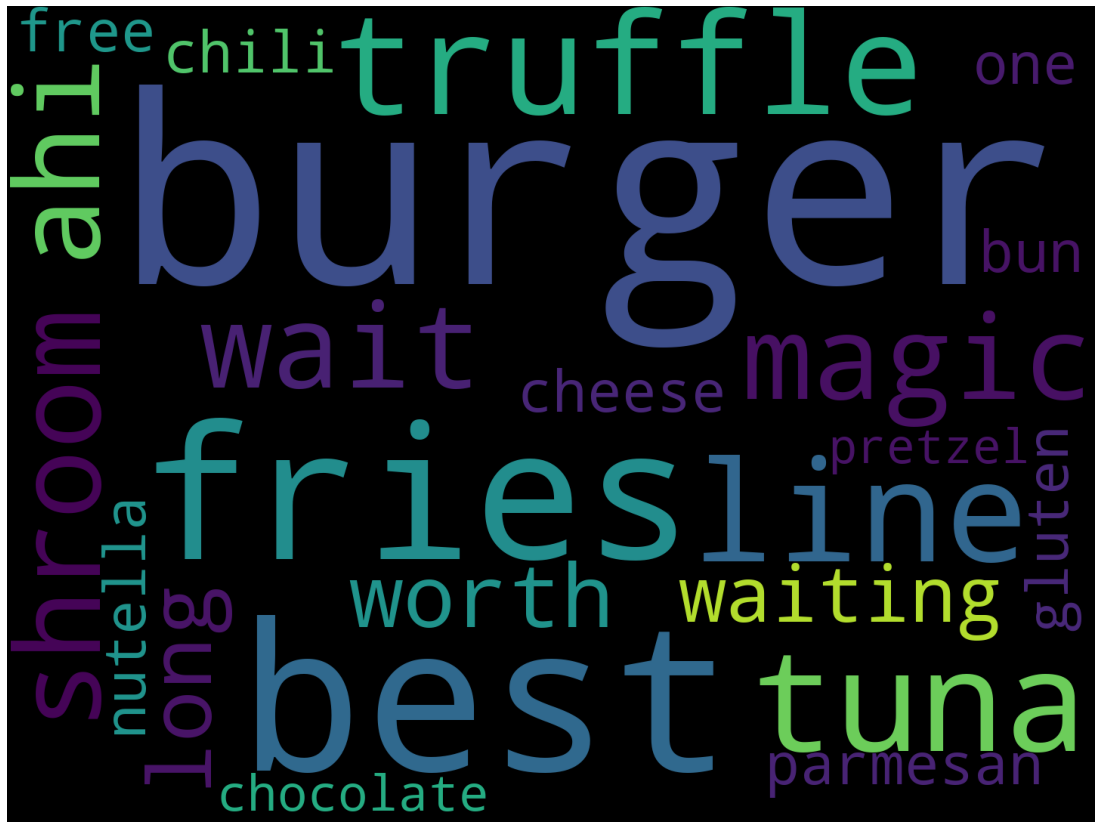

In [ ]:
#positive review
num_business_analysis = 1 # basically this will tell how much computing and diverse our analysis will be
business_ids=  top_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names =   top_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = df_yelp_review.loc[df_yelp_review['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))

Analysing business:  Barking Crab
----- 10 most common 2-word phrase -----
barking crab: 360
lobster roll: 287
clam chowder: 121
crab cakes: 99
crab legs: 89
tourist trap: 86
food good: 74
fish chips: 74
picnic tables: 65
pretty good: 64

----- 10 most common 3-word phrase -----
naked lobster roll: 44
lobster mac cheese: 26
sweet potato fries: 24
barking crab great: 16
peel eat shrimp: 16
crab cake sliders: 15
hot crab dip: 15
king crab legs: 14
lobster roll good: 13
went barking crab: 13



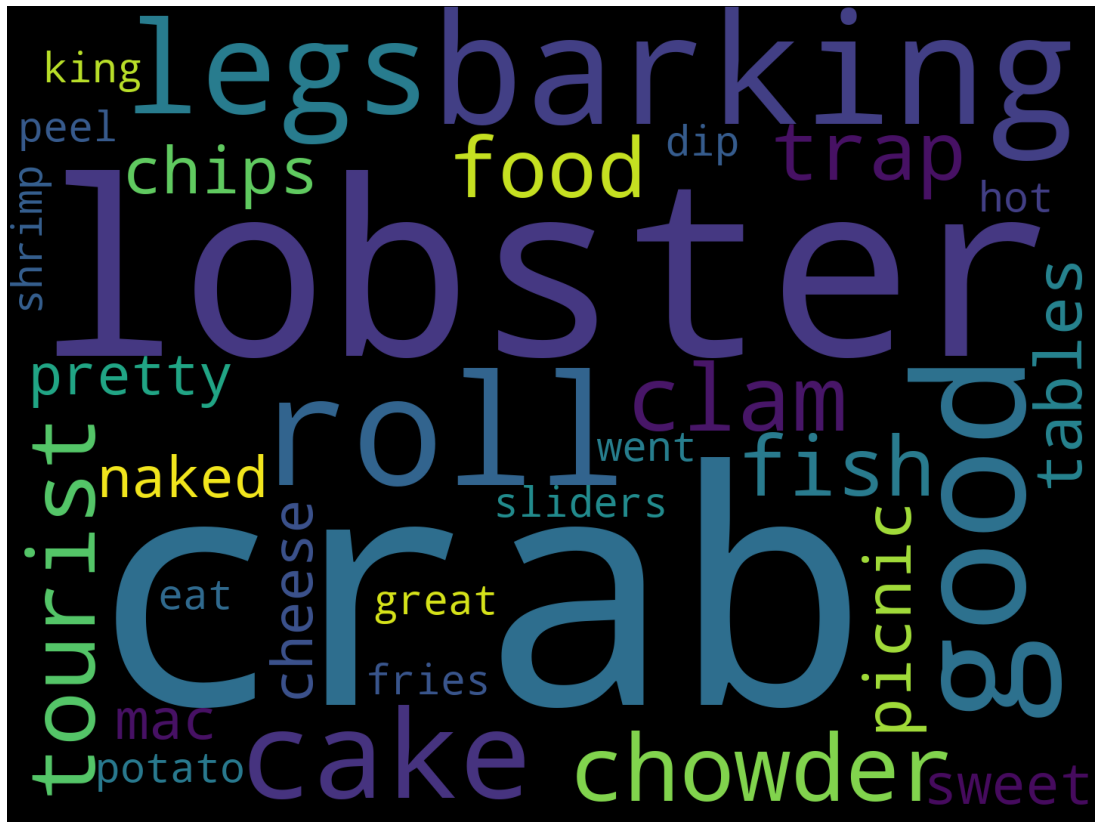

In [ ]:
#negative review
num_business_analysis = 1 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = df_yelp_review.loc[df_yelp_review['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))

## **Most frequent tips**

Analysing business:  Barking Crab
----- 10 most common 2-word phrase -----
lobster roll: 12
clam chowder: 6
live music: 5
lobster rolls: 5
great food: 4
king crab: 4
tourist trap: 4
good place: 4
fish chips: 3
fisherman platter: 3

----- 10 most common 3-word phrase -----
man v food: 2
peel eat shrimp: 2
today lunch fish: 1
lunch fish chips: 1
fish chips fisherman: 1
chips fisherman platter: 1
fisherman platter picture: 1
platter picture follow: 1
picture follow electric: 1
follow electric lemonade: 1

----- 10 most common 4-word phrase -----
today lunch fish chips: 1
lunch fish chips fisherman: 1
fish chips fisherman platter: 1
chips fisherman platter picture: 1
fisherman platter picture follow: 1
platter picture follow electric: 1
picture follow electric lemonade: 1
follow electric lemonade new: 1
electric lemonade new favorite: 1
lemonade new favorite world: 1



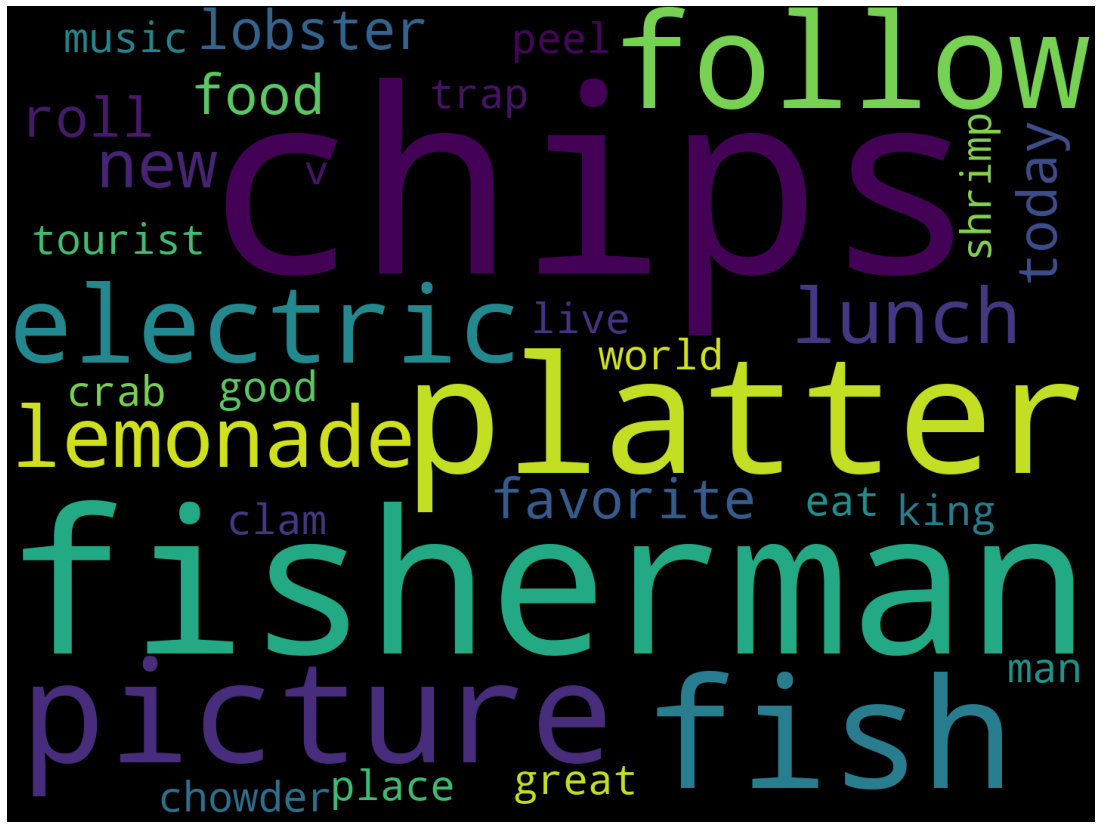


Analysing business:  Westgate Lakes Resort and Spa
----- 10 most common 2-word phrase -----
stay away: 4
customer service: 3
service everything: 2
never return: 2
come back: 2
away place: 2
resale value: 2
value timeshares: 2
timeshares found: 2
worst experience: 2

----- 10 most common 3-word phrase -----
customer service everything: 2
stay away place: 2
resale value timeshares: 2
worst experience ever: 2
roaches bathroom worst: 1
bathroom worst customer: 1
worst customer service: 1
customer service customer: 1
service customer service: 1
service everything get: 1

----- 10 most common 4-word phrase -----
roaches bathroom worst customer: 1
bathroom worst customer service: 1
worst customer service customer: 1
customer service customer service: 1
service customer service everything: 1
customer service everything get: 1
service everything get f: 1
everything get f entire: 1
get f entire front: 1
f entire front desk: 1



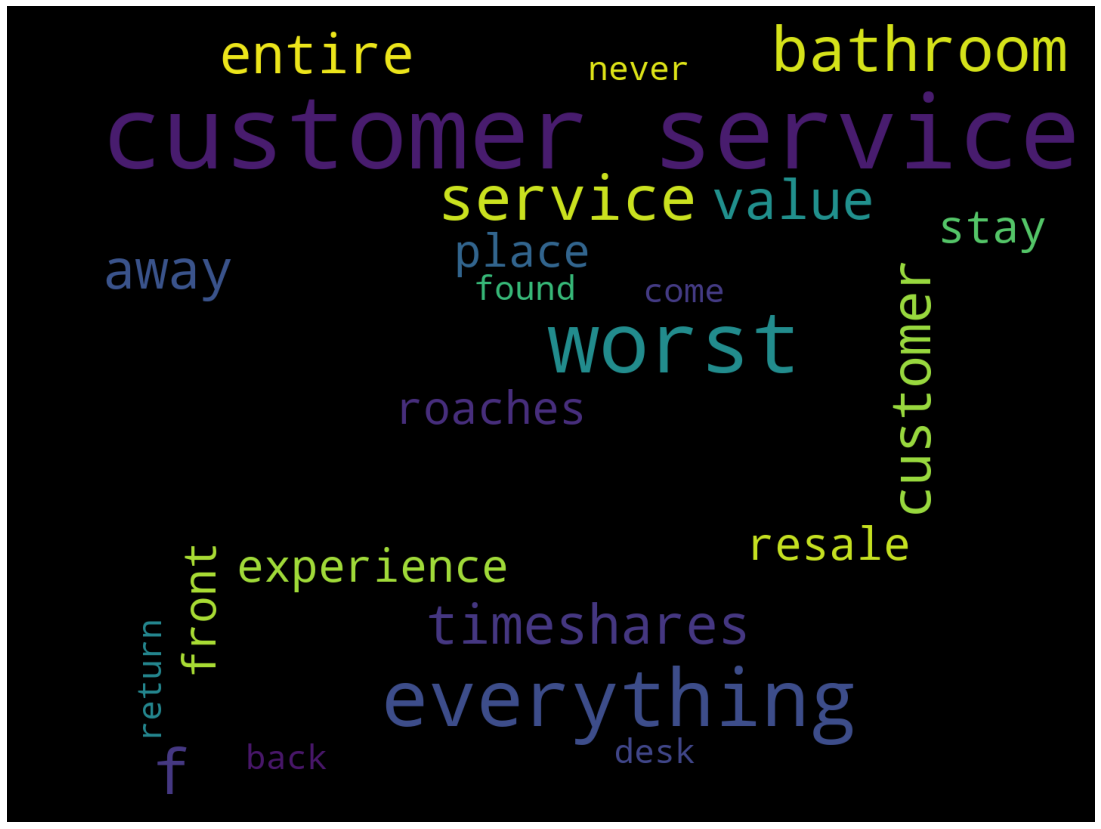

In [ ]:
num_business_analysis = 2 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = df_yelp_tips.loc[df_yelp_tips['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=4)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))

# **Modelling**

## **Predict Yelp Rating from Review Text**

In [ ]:
df_yelp_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
13,ufCxltuh56FF4-ZFZ6cVhg,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, American (New), Bakeries, Dessert...","{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18..."


In [ ]:
df_yelp_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,apparently prides osteria rough summer evidenc...,2014-10-11 03:34:02,2014
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,i have stayed many marriott renaissance marrio...,2010-01-08 02:29:15,2010
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,food always great here service manager well st...,2011-07-28 18:05:01,2011
5,J4a2TuhDasjn2k3wWtHZnQ,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,1,2,0,0,place used cool chill place bunch neanderthal ...,2018-01-21 04:41:03,2018
6,28gGfkLs3igtjVy61lh77Q,Q8c91v7luItVB0cMFF_mRA,EXOsmAB1s71WePlQk0WZrA,2,0,0,0,setting perfectly adequate food comes close di...,2006-04-16 02:58:44,2006


In [ ]:
# split data
from sklearn.model_selection import train_test_split

# preprocessing and layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# visualisasi plot
import matplotlib.pyplot as plt

In [ ]:
a = df_yelp_business[df_yelp_business['categories'].str.contains('Restaurant') == True]
rev = df_yelp_review[df_yelp_review.business_id.isin(a['business_id']) == True]

In [ ]:
rev_samp = rev.sample(n = 35000, random_state = 42)
train = rev_samp[0:28000]
test = rev_samp[28000:]

In [ ]:
train.shape, test.shape

((28000, 10), (7000, 10))

,text,stars
326067,went last night town guests weather amazing ou...,3
219640,always great time pig ! place great weekends n...,5
377071,almost ingredients great restaurant decor amb...,1
179022,looking good hole wall korean eatery boston ar...,5
117792,great service love food quality never overcook...,5


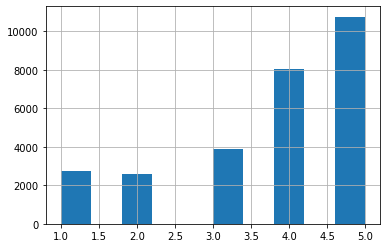

In [ ]:
#train = pd.read_csv('/home/adam/R/Yelp/dataset/model_train.csv', usecols = ['text', 'stars'])
train = train[['text', 'stars']]
train['stars'].hist();train.head()

In [ ]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
326067,went last night town guests weather amazing ou...,0,0,1,0,0
219640,always great time pig ! place great weekends n...,0,0,0,0,1
377071,almost ingredients great restaurant decor amb...,1,0,0,0,0
179022,looking good hole wall korean eatery boston ar...,0,0,0,0,1
117792,great service love food quality never overcook...,0,0,0,0,1


In [ ]:
# Change the data type to str and numpy array 
text = train['text'].astype(str)
label = train[['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']].values

In [ ]:
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

In [ ]:
# convert to sequence
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [ ]:
model = Sequential([
    Embedding(input_dim=9000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nThe train and validation accuracy obtained has reached the value of > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
num_epochs = 15
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/15
700/700 - 167s - loss: 0.7020 - accuracy: 0.7002 - val_loss: 1.0586 - val_accuracy: 0.5591
Epoch 2/15
700/700 - 169s - loss: 0.6574 - accuracy: 0.7243 - val_loss: 1.1382 - val_accuracy: 0.5500
Epoch 3/15
700/700 - 171s - loss: 0.6178 - accuracy: 0.7446 - val_loss: 1.2075 - val_accuracy: 0.5575
Epoch 4/15
700/700 - 175s - loss: 0.5695 - accuracy: 0.7708 - val_loss: 1.2691 - val_accuracy: 0.5470
Epoch 5/15
700/700 - 175s - loss: 0.5232 - accuracy: 0.7918 - val_loss: 1.3663 - val_accuracy: 0.5452
Epoch 6/15
700/700 - 173s - loss: 0.4881 - accuracy: 0.8104 - val_loss: 1.4342 - val_accuracy: 0.5318
Epoch 7/15
700/700 - 174s - loss: 0.4436 - accuracy: 0.8289 - val_loss: 1.6081 - val_accuracy: 0.5421
Epoch 8/15
700/700 - 174s - loss: 0.4007 - accuracy: 0.8484 - val_loss: 1.6506 - val_accuracy: 0.5204
Epoch 9/15
700/700 - 176s - loss: 0.3687 - accuracy: 0.8629 - val_loss: 1.9175 - val_accuracy: 0.5205
Epoch 10/15
700/700 - 178s - loss: 0.3302 - accuracy: 0.8788 - val_loss: 1.9567 - 

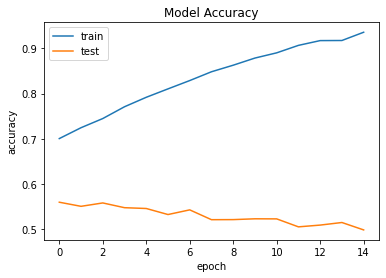

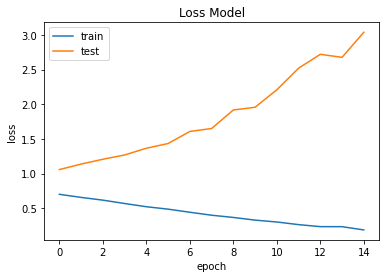

In [ ]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Recommendation System**

In [ ]:
# to choose a restaurant, just copy the business id and paste it in the next cell
# you can always rerun the cell to choose another restuarant. 
df_yelp_business.sample(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
7220,DHw6c9B-gThuIbsRo5b1IA,Jersey Mike's Subs,2014 Powers Ferry Rd,Atlanta,GA,30339,33.903366,-84.460465,3.5,55,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Restaurants, Fast Food, Sandwiches, Delis","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
4771,pw1GOdx54tJClcUvHB7kvA,Kitchen,560 Tremont St,Boston,MA,02118,42.343801,-71.071900,4.0,236,0,"{'NoiseLevel': 'u'average'', 'RestaurantsPrice...","American (Traditional), Restaurants, American ...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
7577,zVQhVSZyK09SbJYhQXj97g,New Age Chinese Cuisine,5411 Kingsway,Burnaby,BC,V5H 2G1,49.223985,-122.985808,4.0,5,0,"{'RestaurantsReservations': 'True', 'Restauran...","Taiwanese, Restaurants",NA
2350,ZWAobV9Ek53H6elHoa9TuA,Thai Express,200 Granville Street,Vancouver,BC,V6C 1S4,49.287718,-123.115132,2.5,26,1,"{'RestaurantsReservations': 'False', 'Restaura...","Thai, Food Court, Restaurants",NA
3144,vRLrf0GcAFpQJF9Tnoht4g,Tipico Bar and Grill,16 Broadway,Kissimmee,FL,34741,28.292141,-81.407336,4.5,6,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Caribbean, Puerto Rican, Dominican","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
13154,RvTZl0uOcBfjOTa10wwt-g,Banya Japanese Restaurant,8166 SW Hall Blvd,Beaverton,OR,97008,45.461220,-122.793375,4.0,179,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Japanese, Restaurants","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."
11201,yoC6qatkF40bjRsCMh7b-A,Pizza Hut,"136 Andover St, Ste C",Danvers,MA,01923,42.556353,-70.968354,2.5,28,0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Restaurants, Italian, Pizza, Chicken Wings","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
10834,52VsWopSWRj6ofcpE8aD3w,Lickerish Restaurant & Lounge,903 Davie Street,Vancouver,BC,V6Z 2E9,49.278685,-123.128330,3.0,43,0,"{'GoodForKids': 'False', 'RestaurantsPriceRang...","Restaurants, Nightlife, Music Venues, Lounges,...","{'Monday': '17:0-1:0', 'Tuesday': '17:0-1:0', ..."
6282,dzJLck373Ll0BgLWKnj8_Q,Lek Thai Food,3145 SE Hawthorne Blvd,Portland,OR,97214,45.512196,-122.632865,3.5,7,0,"{'RestaurantsPriceRange2': '1', 'GoodForKids':...","Restaurants, Thai, Food",NA
2496,MlXsuBBd9UwgBkQzrGDJqA,LanZhou Ramen,5231 Buford Hwy NE,Doraville,GA,30340,33.894818,-84.282134,4.0,471,1,"{'BikeParking': 'False', 'DogsAllowed': 'False...","Chinese, Restaurants, Japanese, Ramen","{'Monday': '10:30-21:30', 'Tuesday': '10:30-21..."


In [ ]:
import operator
from scipy.spatial.distance import cdist

def business_choose(name):
    new_reviews = df_yelp_review.loc[df_yelp_review['business_id'] == name, 'text']
    
    new_categories = df_yelp_business.loc[df_yelp_business['business_id'] == name, 'categories']
    
    # find most similar reviews
    dists1 = cdist(vectorizer_reviews.transform(new_reviews).todense().mean(axis=0), 
              vectorized_reviews.T.dot(businessxreview).T.todense(), 
               metric='correlation')
    
    # find most similar categories
    dists2 = cdist(vectorizer_categories.transform(new_categories).todense().mean(axis=0), 
              vectorized_categories.todense(), 
               metric='correlation')
    
    # combine the two vectors in one matrix
    dists_together = np.vstack([dists1.ravel(), dists2.ravel()]).T
    
    # this is a key cell: how are we going to prioritize ?
    dists = dists_together.mean(axis=1)
    
    # select the closest 10
    closest = dists.argsort().ravel()[:10]
    
    display('Selected Business => ',df_yelp_business.loc[df_yelp_business['business_id']== name, ['business_id', 'categories', 'name', 'stars']])
    
    display('Recomended Business => ',df_yelp_business.loc[df_yelp_business['business_id'].isin(df_yelp_business['business_id'].iloc[closest]), ['business_id', 'categories', 'name', 'stars']])

In [ ]:
business_choose('dzJLck373Ll0BgLWKnj8_Q')

'Selected Business => '

,business_id,categories,name,stars
6282,dzJLck373Ll0BgLWKnj8_Q,"Restaurants, Thai, Food",Lek Thai Food,3.5


'Recomended Business => '

,business_id,categories,name,stars
2602,4CIymwx0FUsAw_OyxFixSQ,"Restaurants, Thai",Thai Time Cafe,4.0
4041,q5vqWsT1EeRJjJrAAgI-lw,"Restaurants, Coffee & Tea, Breakfast & Brunch,...",Barnie's Coffee,4.5
9490,g8RrcJp2GwgslYh9v8-LMA,"Restaurants, Food, Food Trucks, Thai",Bua Loy Thai Cuisine,3.5
10601,-RpXYkc-4WDM4iJhgc4e2A,"Restaurants, Delis",Belmont Deli,4.5
10895,VbOvUSeBCpsw6T6RFFo6lQ,"Food Delivery Services, Vietnamese, Food, Rest...",Pho's Asian,2.0
10995,Yns2eROqk-f4BUL8YiuBAA,"Restaurants, Thai",Ma Now Thai Kitchen,4.5
12121,m1RAtwhe2MJU_rVidrbRXA,"Thai, Restaurants",Green Basil Thai Restaurant,3.0
13230,AuwGx9r5Z2oIaOrkcVDpXw,"Thai, Restaurants",iThai Restaurant,4.0
13574,JWf3qCoPdI7FEWNfyNbxIw,"Food, Vietnamese, Food Trucks, Restaurants",Mary's Cuisine,4.0
14568,fTq-Lu0BVM82_9XRiAPQBA,"Restaurants, Thai",Golden Thai,4.5
